<a href="https://colab.research.google.com/github/saitejamalyala/8051/blob/gh-pages/wandb_demo_settings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wandb Demo

3 Simple steps

1.   Initialize
2.   Log
  * Metrics
  * Tables (All Rich Media)
  * Artifacts

3. Finish






In [ ]:
!pip install wandb

# Imports 📑

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
import random, os
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    ReLU,
    BatchNormalization,
    Add,
    Dense,
    GlobalMaxPool2D,
    MaxPool2D,
)
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import wandb
from typing import List, Dict, Tuple, Any, Optional, Union
from numpy import ndarray
from tensorflow.keras import optimizers 
import pathlib

import seaborn as sns
from sklearn.metrics import classification_report
import plotly.express as px

#from wandb import config as config
import wandb
from wandb.keras import WandbCallback

class_names =  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Config ⚙️

In [4]:
config={}
# Dataset config
config['batch_size'] = 32
config['img_height'] = 180
config['img_width'] = 180
config['validation_split'] =0.3
config['optimize_ds'] = False

## Model config
config['augment_data']=False
config['num_classes'] = len(class_names)
config['num_conv_layers'] = 3
config['conv_filter_0'] = 16
config['conv_filter_1'] = 32
config['conv_filter_2'] = 64
config['conv_kern_size_0'] = 3
config['conv_kern_size_1'] = 3
config['conv_kern_size_2'] = 3
config['conv_activ'] = 'relu'

config['maxpool_kern_size'] = 2

config['dense_units'] = 128
config['dense_activ'] = 'relu'
config['dropout_rate'] = 0.0

# optimizer params
config['optimizer'] = 'adam'
config['learning_rate'] = 0.001

# training params
config['epochs'] = 10

# Helper Functions 🤝

In [5]:
def set_seed(seed: int = 2022) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    tf.set_random_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

def convert_tfdata2numpy(test_ds) -> Union[ndarray, ndarray]:
    #IMG_SIZE = params.get("img_size")
    np_test_images = np.zeros(shape=(config["testset_len"], config['img_height'], config['img_width'], 3))
    np_test_labels = np.zeros(shape=(config["testset_len"],))
    j = 0
    for image_batch, label_batch in test_ds:
        for i in range(image_batch.numpy().shape[0]):
            np_test_images[j] = image_batch.numpy()[i]
            np_test_labels[j] = label_batch.numpy()[i]
            j += 1

    return np_test_images, np_test_labels

def get_optimizer(config):
    if config['optimizer'] == 'adam':
        return optimizers.Adam(learning_rate=config['learning_rate'])
    if config['optimizer'] == 'nadam':
        return optimizers.Nadam(learning_rate=config['learning_rate'])
    if config['optimizer'] == 'rmsprop':
        return optimizers.RMSprop(learning_rate=config['learning_rate']) 
    if config['optimizer'] == 'sgd':
        return optimizers.SGD(learning_rate=config['learning_rate'])
    
    return optimizers.Adam(learning_rate=config['learning_rate'])


def make_gradcam_heatmap(
    img_array: ndarray,
    model: keras.Model,
    last_conv_layer_name: str = "conv2d_2",
    pred_index=None,
) -> ndarray:

    """construct gradcam based heatmap
    Args:
        img_array (ndarray): numpy image array (4 dimensions, including the batch size)
        model (tf.keras.Model): trained keras model
        last_conv_layer_name (str, optional): name of the last convolutional layer. Defaults to 'conv2d_12'.
        pred_index ([type], optional): [description]. Defaults to None.
    Returns:
        ndarray: heatmap array
    """

    img_array = np.expand_dims(np.fliplr(img_array),axis=0)
    last_conv_layer_name = model.layers[-6].name

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    plt.imshow(heatmap.numpy().astype('float'),cmap='jet')
    plt.axis('off')
    plt.tight_layout()
    return plt

In [6]:
def get_model(config) -> tf.keras.Model:
   
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(config['img_height'], config['img_width'], 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )

    model = Sequential([
        data_augmentation,
      layers.Rescaling(1./255, input_shape=(config['img_height'], config['img_width'], 3)),

      layers.Conv2D(config['conv_filter_0'], config['conv_kern_size_0'], padding='same', activation=config['conv_activ']),
      layers.MaxPooling2D(config['maxpool_kern_size']),

      layers.Conv2D(config['conv_filter_1'], config['conv_kern_size_1'], padding='same', activation=config['conv_activ']),
      layers.MaxPooling2D(config['maxpool_kern_size']),

      layers.Conv2D(config['conv_filter_2'], config['conv_kern_size_2'], padding='same', activation=config['conv_activ']),
      layers.MaxPooling2D(config['maxpool_kern_size']),
      layers.Dropout(0.2),
      layers.Flatten(),

      layers.Dense(config['dense_units'], activation=config['dense_activ']),
      layers.Dense(config['num_classes'])
    ])

    model.compile(optimizer=get_optimizer(config),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model


In [7]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total Images: {image_count}')

def get_dataset(config):
  # training dataset
  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=config['validation_split'],
    subset="training",
    seed=123,
    image_size=(config['img_height'], config['img_width']),
    batch_size=config['batch_size'])


  # validation dataset
  val_ds  = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=config['validation_split'],
    subset="validation",
    seed=123,
    image_size=(config['img_height'], config['img_width']),
    batch_size=config['batch_size'])

  # test set
  val_batches = tf.data.experimental.cardinality(val_ds)
  test_ds = val_ds.take(val_batches // 5)
  val_ds = val_ds.skip(val_batches // 5)

  print(f'Test data set size : {tf.data.experimental.cardinality(test_ds)* config["batch_size"]}')
  config["testset_len"] = tf.data.experimental.cardinality(test_ds)* config["batch_size"]

  class_names = train_ds.class_names
  print(f'Class Names from the dataset: {class_names}')

  ### Optimize dataset ###
  if config['optimize_ds']:
      AUTOTUNE = tf.data.AUTOTUNE
      train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
      val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  return train_ds,val_ds,test_ds


228813984/228813984 [==============================] - 4s 0us/step
Total Images: 3670



# Training 🏋️

*   Log Metrics 📈📊 ✨   

![image.png](https://assets.website-files.com/5ac6b7f2924c656f2b13a88c/6179c2c3df4d1d0229610b9c_Experiments%20Tile.svg)

In [8]:
#@title settings
#@markdown 
use_wandb = False #@param {type:"boolean"}
optimize_dataset = False #@param {type:"boolean"}
augment_data = False #@param {type:"boolean"}
add_dropout = 0.55 #@param {type:"number", min:0.1, max:0.9}
relogin = False #@param {type:"boolean"}

In [ ]:
wandb.login(relogin=relogin)


if optimize_dataset:
  config['optimize_ds'] = True
if augment_data:
  config['augment_data']=True
config['dropout_rate']=add_dropout


# 1. get dataset
train_ds,val_ds,test_ds = get_dataset(config)

# 2. compile and build model
model = get_model(config)
model.summary

if use_wandb:
  # 1️⃣
  run=wandb.init(project="image_classification",notes=notes ,config=config, settings=wandb.Settings(start_method="thread"))
  np_test_images,np_test_labels = convert_tfdata2numpy(test_ds)
  # 2️⃣ keras callback to log, gradients, weights, sample predictions on test data
  cb=[WandbCallback(training_data=train_ds,log_weights=True,log_gradients=True,
                        validation_data=(np_test_images[:20],np_test_labels[:20]),
                        validation_steps=7,input_type='image',output_type='label',
                        labels=class_names,predictions=20,log_evaluation=True)]
else:
  cb=[]

# 3. train model
history=model.fit(train_ds, validation_data = val_ds,
                  epochs=config['epochs'],
                  callbacks=cb
                  )

if use_wandb:
  # 3️⃣
  #wandb.finish()
  pass

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Found 3670 files belonging to 5 classes.
Using 2569 files for training.
Found 3670 files belonging to 5 classes.
Using 1101 files for validation.
Test data set size : 224
Class Names from the dataset: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Epoch 1/10
81/81 [==============================] - 17s 97ms/step - loss: 1.4837 - accuracy: 0.3499 - val_loss: 1.2389 - val_accuracy: 0.4983
Epoch 2/10
81/81 [==============================] - 8s 93ms/step - loss: 1.0969 - accuracy: 0.5477 - val_loss: 1.5042 - val_accuracy: 0.4344
Epoch 3/10
81/81 [==============================] - 8s 93ms/step - loss: 1.0011 - accuracy: 0.5956 - val_loss: 1.0426 - val_accuracy: 0.6089
Epoch 4/10
81/81 [==============================] - 11s 127ms/step - loss: 0.9384 - accuracy: 0.6283 - val_loss: 1.0281 - val_accuracy: 0.5975
Epoch 5/10
81/81 [==============================] - 8s 95ms/step - loss: 0.8706 - accuracy: 0.6606 - val_loss: 0.9268 - val_accuracy: 0.6659
Epoch 6/10
81/81 [=================

## Boiler plate for plotting

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config['epochs'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Logging Rich Media
* Log Rich Media (To Visualize during training) 🖼️, 📹, 🔊
*   Logging Evaluation results (Qualitatively)
*   Upload CAM results along

![image.svg](https://assets.website-files.com/5ac6b7f2924c656f2b13a88c/617c9275f882bfd7e3907b55_tables.svg)


## Predict on test set

In [ ]:
predictions = model.predict(np_test_images)
scores = tf.nn.softmax(predictions,axis=1)
predict_class = np.argmax(scores,axis=1)
predict_class_names = [class_names[int(prediction)] for prediction in  predict_class]
label_class_names = [class_names[int(label)] for label in  np_test_labels]

7/7 [==============================] - 0s 13ms/step


## Log to tables 🔥

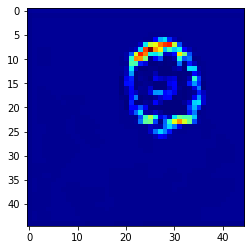

In [ ]:
# Plot 1 - Confusion Matrix plotly figure

confusion_mtx = tf.math.confusion_matrix(
    #list(test_ds.map(lambda x, y: y)),
    np_test_labels,
    predict_class,
    num_classes=config['num_classes'])

path_to_cm_html = "./plotly_cm.html"
fig1=px.imshow(confusion_mtx,text_auto=True,x=class_names,y=class_names)
fig1.update_xaxes(side="top")
fig1.show()
fig1.write_html(path_to_cm_html, auto_play = False) 


# Plot 2- Classification report

cr=pd.DataFrame(classification_report(np_test_labels, predict_class,target_names=class_names,output_dict=True)).transpose()
path_to_cr_html = "./plotly_figure.html"
fig=px.imshow(cr,text_auto=True,zmin=0.5,zmax=0.9)
fig.update_xaxes(side="top")
fig.show()
fig.write_html(path_to_cr_html, auto_play = False) 


# Logging Data to Tables

test_data_logging = [[wandb.Image(image),wandb.Image(make_gradcam_heatmap(image,model=model)),class_names[int(prediction)],class_names[int(label)],score] for image, prediction, label, score in zip(np_test_images, predict_class, np_test_labels, scores)]    

test_data_table=wandb.Table(data=test_data_logging,columns=["images","CAM","predictions","labels","scores"])

# logging plot 1 to tables
classifiction_report_table = wandb.Table(data=cr,rows=cr.index)
wandb.log({"test_data":test_data_table})

# Create a table
cm_table = wandb.Table(columns = ["plotly_figure"])
# Add Plotly figure as HTML file into Table
cm_table.add_data(wandb.Html(path_to_cm_html))
# Log Table
wandb.log({"plotly_cm": cm_table})


# logging plot 2 to tables
cr_table = wandb.Table(columns = ["plotly_figure"])
cr_table.add_data(wandb.Html(path_to_cr_html))
wandb.log({"plotly_cr": cr_table})

#wandb.finish()


# Log Artifacts 🏺

1. Model as a artifact 🕸️
2. Dataset as a artifact (Light weight) 💾

![artifacts.svg](https://assets.website-files.com/5ac6b7f2924c656f2b13a88c/617c32bec49ad74cb23d0436_artifacts.svg)

In [ ]:
# Usual way of save model
fn='model.h5'
model.save(fn)

## Model Registry ##

#  At the end of training, save the model artifact
# Name this artifact after the current run
model_artifact_name = "demo_model_" + run.id
# 1️⃣ Create a new artifact 
model_artifact = wandb.Artifact(model_artifact_name, type='model')
# 2️⃣ Add files to the artifact, in this case a simple text file
model_artifact.add_file(fn)
# 3️⃣ Log the model to W&B
run.log_artifact(model_artifact)

wandb.finish()

## Use Artifacts



*   Load existing model artifact
*   Evaluate on new data or test set




In [ ]:
wandb.init()
artifact = wandb.use_artifact('saitejam/image_classification/demo_model_12qgj4mb:v0', type='model')
artifact_dir = artifact.download()
artifact_model = tf.keras.models.load_model(os.path.join(artifact_dir,'model.h5'))

wandb:   1 of 1 files downloaded.  


In [ ]:
#artifact_model.summary()
test_loss,test_accuracy = artifact_model.evaluate(test_ds)
wandb.log({'test_loss':test_loss,'test_accuracy':test_accuracy})
wandb.finish()

7/7 [==============================] - 2s 123ms/step - loss: 0.9082 - accuracy: 0.6295


0.6294642686843872

# Custom training loop

In [ ]:
#@title Options
#@markdown Forms support many types of fields.
use_wandb = True #@param {type:"boolean"}

In [ ]:
# Instantiate an optimizer.
optimizer = get_optimizer(config)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# model
model=get_model(config)

import time

In [ ]:
## 1️⃣ init
wandb.init(project="image_classification", notes='Custom training loop',config=config)

config['epochs']=10

for epoch in range(config['epochs']):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)
        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * config['batch_size']))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_ds:
        val_logits = model(x_batch_val, training=False)
        val_loss = loss_fn(y_batch_val, val_logits)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))

    if use_wandb:
      ## 2️⃣ logging ##
      wandb.log({'loss':loss_value},step=epoch)
      wandb.log({'accuracy':train_acc},step=epoch)
      wandb.log({'val_loss':val_loss},step=epoch)
      wandb.log({'val_accuracy':val_acc},step=epoch)

if use_wandb:
  # 3️⃣
  wandb.finish()

# Sweeps 🧹
![sweeps.svg](https://assets.website-files.com/5ac6b7f2924c656f2b13a88c/6179d7b3ce0fba86cce2bc7c_wandb%20sweeps.svg)

In [ ]:
#@title settings
#@markdown 
run_count = 10 #@param {type:"number"}
run_sweep = False #@param {type:"boolean"}

## Sweep Config 🛠️


Two ways to specify sweep configuration:
1.   A **Config** dictionary
2.   **Yaml**

Sweep stragtegies:


1.   **Grid** Search
2.   **Random** Search
3.   **Bayesian**




In [ ]:
# Define sweep config
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        'epochs': {'values': [10, 15, 20, 25, 30]},
        'learning_rate': {'max': 0.01, 'min': 0.0001},
        'dropout_rate':{'max': 0.6, 'min': 0.2},
        'conv_filter_0': {'values': [8,16, 32, 64]},
        'conv_filter_1': {'values': [8,16, 32, 64]},
        'conv_filter_2': {'values': [8,16, 32, 64]},
        'dense_units':{'values': [8, 16, 32, 64, 128]},
        'optimizer': {'values': ['nadam','adam','rmsprop','sgd']}        
        
     }
}

if run_sweep:
  ## 1️⃣
  # Initialize sweep by passing in config. (Optional) Provide a name of the project.
  sweep_id = wandb.sweep(sweep=sweep_configuration, project='image_classification')

## sweep agent 🕵️

Other features
*   Create configuration from existing runs (if there are any)
*   **Full control**: start, stop, pause 
*   **Early stoppping**
*   Parameter importance
*   **Parallelize** agents (also to use two different GPUs) : just use the same *sweep ID* and you are sorted


In [ ]:
# 1. get dataset
train_ds,val_ds,test_ds = get_dataset(config)

def train():

  # Step2: Initialize W&B run
  ## 2️⃣
  wandb.init()
  
  config.update(wandb.config)

  # 2. compile and build model
  model = get_model(config)

  # 3. train model
  wandb_cb = WandbCallback(training_data=train_ds,log_weights=True,log_gradients=True,save_models=True,
                            validation_data=(np_test_images[:20],np_test_labels[:20]),
                            validation_steps=7,input_type='image',output_type='label',
                            labels=class_names,predictions=20,log_evaluation=True)

  history = model.fit(train_ds, validation_data=val_ds,
                      epochs=config['epochs'],
                      callbacks=[wandb_cb]
                      )

if run_sweep:
  # Start sweep job.
  # 3️⃣
  wandb.agent(sweep_id, function=train, count=run_count)

# Reports 📝



*   Doccument your insights 💡
*   Distill the information from the runs ℹ️
*   Share within the team and between the teams 📜
